### "Call a daggum timeout!"

-Roy Williams, probably never

## Introduction

Basketball fans generally believe that calling timeouts can slow or stop scoring runs. Certain coaches (famously, Roy Williams) are often criticized for not calling timeouts when their teams are on the wrong side of a scoring run (referred to as the "slipping" team in this work). Fans can be insistent that timeouts <i>must</i> be called in these situtions. However, to the best of my knowledge, this general wisdom has never been tested nor supported by any actual analysis. Previously, I explored this relationship using Bayesian statistics to suggest that calling a timeout either has no effect on or even decreases the probability of runs ending. This analysis had some flaws, largely because 1. the criteria for "ending" a run are unclear, and 2. there are so many timeouts in college basketball that the prior probability of a run ending was perhaps inaccurate (in that work, two timeouts called without the slipping team returning to trading scores). 

To address these issues, I looked to a method that requires no parameterization to determine when a run is considered over. The expected value of a timeout can be used to determine whether timeouts have the desired effect. That is, if a timeout is called, we can look at the average change in score over the next few scores and compare that value with the average score of a similar run when no timeout was called (or a different type of timeout was called). Briefly, Scoring runs are categorized by their point values and divided based on the "terminating" event (home timeout, away timeout, official timeout, or no timeout). Then, the expected value (i.e., average score) of the sequences of events that occur after the run is calculated. We can then say that a timeout has an expected value that is greater than, less than or equal to the expected value when nothing is done.


In this work, we will show the following:

1. Runs regress to the mean naturally. That is, teams should expect to return to trading baskets on average in the absence of a timeout ($\Delta$ScoreMargin = 0).

2. The effect of unbiased time stoppages (i.e., official timeouts) is the same as no time stoppage (score change = 0). *There is no evidence for any kind of settling or momentum effect due to calling a timeout.*

3. The effect of calling a timeout is nearly independent of the previous scoring sequence (N.B.: there is a noticeable Home Court advantage). In other words, the effects of timeouts are effectly constant, regardless of the previous sequence of events including the size of a run.

4. On average, not calling a timeout is better for the slipping team than any kind of stoppage in play. After all, both teams get to use the timeout, why wouldn't the running team also be able to rest and improve their strategy?


## Background

Scoring runs are expected in any contest just by chance. This can easily be seen from simple coin flips. If a team is expected to convert 50% of their possessions (equivalent to a coin flip), then they can be expected to convert several in a row while the other team converts none. In this way, scoring runs should occur in most basketball contests. In the same way, these scoring runs should be expected to follow similar probability distributions for when they end. That is, after a scoring run starts, it should have a predictable probability of ending due to the same effect of chance.

The most common reason that fans believe timeouts should be called is settling "frazzled" players or slowing momentum. However, if runs are expected statistical results, these intangible factors should not receive much consideration. Players should be expected to recognize these "slumps" and "streaks" as statistically probable events and know how to handle them. I would even suggest that experience with these events, i.e., "playing through" a cold streak or weathering runs towards the ends of games, results in increased overall win percentage and, in particular, improved post-season success. Excessively calling timeouts could result in some pretty bad losses when you really need a timeout. <a href="https://youtu.be/7HhZBaCAa80?t=702">Here's a nice example.</a>

<b>Disclaimer: This is all an exercise in statistics and data scraping. I do believe that there are mental components to athletic contests and that scoring is not independent of these factors. However, I think that a coach could easily coach their team to not expect or wait for timeouts in the case of runs, and it would not have a negative effect on their performance. Some of that practice time has to materialize as recognize the mistakes you are making and correcting them without a timeout.</b>

## Methods

In this analysis, we are matching exact scoring/timeout sequences to other sequences and determining what happened after those sequences. Briefly, the method consists of converting scores into a code 'H' or 'A' indicating 'Home' or 'Away' followed by the value of the basket (1-3) or a 'T' for 'Timeout' ('OT' for official/TV timeouts). This method produces a string like "H2H2H2A2H2OTATH2A2H3OTHTH1H1A2". We then use a regular expression search to find all sequences that look like a run. We use this approach to examine all possible 'run' sequences (including a single point). We exclude any sequences that run into the last 90 seconds of a period because clock management because a very import strategic element, and those sequences are considered to be part of a separate population with different behaviors. That is, I don't think ending a run in the last 30 seconds is the same strategic choice as one during the 10th minute.

After finding sequences that match the run criteria, we divide the runs based on the event that ended the run (TO by type, including no TO) and record the value of the next 4 scores. While I believe multiple timeouts should be considered a "failure" for the slipping team, we ignore any additional TOs to keep this analysis simple and clear. We are comparing sequences to see how calling a timeout *in a particular moment* differs from not calling a timeout. It may be worth investigating multiple timeouts or runs that span timeouts in the furture.

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script><h3><b>The raw code for this Jupyter notebook is hidden by default for easier reading.
To toggle the raw code on/off, click <a href="javascript:code_toggle()">here</a>. 
Some of the analysis may be a bit disjoint without the comments in the code. If you are
comfortable reading Python, consider viewing the code, although it can be a bit long at times.</b></h3>''')

In [58]:
# Imports
import csv, sqlite3, re 
from collections import defaultdict
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as scp

from sklearn.linear_model import LinearRegression 

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16,
                    'figure.figsize': (10, 5)})


# Intermediate data are stored in human readable format using these functions
def read_dict(filename):
    """
    Opens the indicated filename and creates a list line by line using the first entry on each line
    as the key and the second as the value
    """
    dictionaryoutput = {}
    with open(filename, encoding='latin-1') as file:
        entries = csv.reader(file)
        for item in entries:
            dictionaryoutput[item[0]] = item[1]
    return dictionaryoutput

def write_dict(outputfilename, dictionary):
    """
    Writes a dictionary to a csv.
    """
    with open(outputfilename, 'w', newline='') as outfile:
        for key, value in dictionary.items():
            outfile.write('%s,%s\n' % (key, value))
            
def write_list(outputfilename, list):
    """
    Writes a list to a csv.
    """
    with open(outputfilename, 'w', newline='') as outfile:
        itemwriter = csv.writer(outfile, delimiter=",")
        for item in list:
            itemwriter.writerow(item)
            
def read_list(filename):
    """
    Opens the indicated filename and creates a list line by line
    """
    listoutput = []
    with open(filename) as file:
        entries = csv.reader(file)
        for item in entries:
            listoutput.append(item)
    return listoutput

def find_run_value(key):
    """
    Takes a sequence of scores (e.g., 'H1H2H2H3H2') and determines the total value of that
    squence. Used to combine different score sequences based on the magnitude of the run.
    
    Values are positive for home streaks and negative for away streaks.
    
    INPUT: String of scoring events
    OUTPUT: Int
    """
    # Determine sign Home is positive Away is negative
    if 'H' in key and 'A' in key or 'T' in key:
        raise ValueError('Something wrong {}'.format(key))
    elif 'H' in key:
        sign = 1
    elif 'A' in key:
        sign = -1
        
    ##key = key.replace('A', '+').replace('H', '+')
    ##
    ### TODO: should be able to get rid of sign and just change this to A -> - H -> +
    ##
    # Nifty way to determine the score of the sequences
    key = key.replace('A', '+').replace('H', '+')
    # Functionally evaluates the string 
    # (This is dangerous, but I've always wanted to use it)
    # I wouldn't set this up in a publically available place
    run_value = eval(key) * sign 
    # More error checking
    if run_value == 0:
        raise ValueError("Score streak evaluated to 0. Key: {}".format(key))
    return run_value

def find_sequence_value(seq, scores=4):
    """
    Counts the first _scores_ scoring events in a sequence, ignoring timeouts and neglecting the
    error checking of find_run_value.
    
    INPUT: Seq = string of events, scores = int indicating number of scoring events to count. 
    OUTPUT: Int
    """
    seq_value = 0
    for c in seq:
        # If it's a timeout or indicating an official timeout, skip
        if c in 'OT':
            continue
        # Set the sign
        elif c == 'A':
            sign = -1
        elif c == 'H':
            sign = 1
        # Add the score with the appropriate sign
        # Will only reach this point if 
        else:
            scores -= 1
            seq_value += sign * int(c)
        if not scores:
            # Return sequence value and sequence minus the last value (looking for parity dependence)
            return seq_value, seq_value - sign * int(c)
    # This will return None if a sequence does not have a length >= scores
    
to_abr = {
            'NoT' : 'No Timeout',
            'OT' : 'Official Timeout',
            'HT' : 'Home Timeout',
            'AT' : 'Away Timeout'
        }
    
    
def set_default(runner, min_score, max_score):
    """
    Sets default score ranges if no score is provided.
    
    INPUT: runner = string indicating team that is running
            min_score, max_score = ints indicating min and max of range
                                if None, default will be inserted
    OUTPUT: min_score, max_score (ints will be passed unchanged)
    """
    
    if runner not in 'HomeAway':
        raise ValueError('Ineligible team name (check capitalization):', runner)
    
    # Set default score range
    # Done here so simplify Home/Away selection
    if not min_score:
        if runner=='Home':
            min_score = 2
        else:
            min_score = -9
    if not max_score:
        if runner=='Home':
            max_score = 10 # not inclusive
        else:
            max_score = -1
            
    return min_score, max_score

def t_test(to_1, to_2, score_dictionary, runner='Home', alpha=0.05, min_score=None, max_score=None):
    """
    """
    
    if not min_score or not max_score:
        min_score, max_score = set_default(runner, min_score, max_score)
        
    bonferroni = abs(max_score - min_score)
    print(bonferroni)
    #alpha = alpha/bonferroni
    
    print('run length\t|\tP value\t|\tT stat\t|\tSignigicant Better\t|\tSignificant Worse')
    for run_length in range(min_score, max_score):
        try:
            tval, pval = scp.ttest_ind(score_dictionary[(run_length, to_1)], \
                            score_dictionary[(run_length, to_2)], equal_var=False)
        except KeyError:
            continue
        
        sig_b = False
        sig_w = False
        if runner == 'Home':
            if tval < 0: # expected value of to_1 < to_2
                pval = 1 - pval
                if pval/2 < alpha:
                    sig_b = True
            elif tval > 0 and pval/2 < alpha:
                sig_w = True
        elif runner == 'Away': # For clarity
            if tval < 0:
                pval = 1 - pval
                if pval/2 < alpha:
                    sig_w = True
            elif tval > 0:
                if pval/2 < alpha:
                    sig_b = True
         
        print('\t{}\t|\t{:.3f}\t|\t{:.3f}\t|\t{}\t|\t{}'.format(run_length, pval, tval, sig_b, sig_w))
        
    
def plot_averages(to_types, score_dictionary, min_score=None, max_score=None, runner='Home',\
                  ylim=(-3.5,3.5)):
    """
    Helper function to plot the average scores.
    """
    
    if not min_score or not max_score:
        min_score, max_score = set_default(runner, min_score, max_score)
    
    
    for to in to_types:
        xs = []
        ys = []
        sem = []
        for run_length in range(min_score,max_score):
            # Might not have values for every point value in the range.
            # If there's no value, skip ahead
            try:
                ys.append(score_dictionary[(run_length, to)].mean())
                sem.append(score_dictionary[(run_length, to)].std() / \
                               np.sqrt(len(score_dictionary[(run_length, to)])))
                xs.append(run_length)
            except KeyError:
                continue
        print('Expected value of {}:\t\t{:.2f} +/- {:.2f}'.format(to_abr[to], (sum(ys)/(len(ys)-1)), np.array(ys).std()))
        lr = sm.OLS(ys, xs).fit()
        print(lr.summary())
        

        #lr.fit(np.array(xs).reshape(-1,1), np.array(ys).reshape(-1,1))
        #print('Correlation of {}:\t\t {:.3f}'.format(to_abr[to], lr.coef_[0][0]))
        try:
            plt.errorbar(xs, ys, yerr=sem, fmt='o', label=to_abr[to])
        except KeyError:
            plt.errorbar(xs, ys, yerr=sem, fmt='o', label=to)
    # Subtract one here to make plot more appealing.
    plt.plot((min_score-1, max_score), (0, 0), 'k-') # Add line at zero
    plt.xlim(min_score-1, max_score)
    plt.ylim(ylim[0], ylim[1])
    plt.title(runner + ' Run Size vs. Change in Score Margin')
    plt.xlabel('Run Size')
    plt.ylabel('Change in Score Margin After Run End')
    plt.legend(loc='lower right')
    if runner=='Away':
        plt.gca().invert_yaxis()
        plt.gca().invert_xaxis()
    plt.show
        

# These dicationaries are created during scraping
# They basically serve to convert 'actor id' into team name
# or abbreviations into to team names. These abbreviations and
# ids are internal ESPN codes that are scraped directly.
ABRDict = read_dict('./ESPN_scraper/ABRdictionary.csv')
NUMDict = read_dict('./ESPN_scraper/NUMdictionary.csv')

#game_sequences = read_list('./data/game_sequences.csv')

In [3]:
# Get data from the DB.
conn = sqlite3.connect('./data/CBBdb.sqlite3')
curr = conn.cursor()

# Exclude bad data
# It might be possible to salvage some of these games as they were frequently a single line where the
# points were added to the wrong team and corrected on the next line. Some games were excluded because
# ESPN did not have labels for them. These games were universally blowouts against very small schools and I think
# it best that they are not included anyway as they are not representative of competitive college games.
# It should be possible to impute this information, but I don't think it would have a meaningful effect on the
# outcomes.

# Games can be plugged into http://www.espn.com/mens-college-basketball/playbyplay?gameId=$game_id$ 
# or #data.loc[(data.game_id == $game_id$)] to view original data.
data = pd.read_sql_query("""SELECT *
                        FROM playbyplay
                        WHERE game_id not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633', '303172239', '290450275',
                        '280472483', '283472390', '290450275', '290650087', '293170041', '260280218', '263240150', 
                        '270170222', '400498526', '400591228', '273332603', '310630171', '253190235', '253532250', 
                        '260020150', '253180142', '253340120', '253422250', '260072608', '260120204', '260230221',
                        '260282507', '260282294', '260310275', '260360152', '263240096', '263330221', '263330264',
                        '263400057', '263572305', '270090275', '270130062', '270152305', '270150097', '270160254',
                        '270232390', '270272305', '270380201', '270460012', '270462509', '270550079', '270672440',
                        '270670120', '273212501', '273512250', '273532086', '280030305', '280050103', '280430258',
                        '280562306', '280590097', '280612181', '280612181', '280660356', '280730235', '283310153',
                        '283402181', '283420052', '290092561', '290350026', '290452752', '290490235', '400869965',
                        '290530183', '290592550', '290660277', '293130153', '293160194', '293172509', '293200041',
                        '293290012', '293392509', '293410251', '293540059', '300090167', '300300096', '303120356',
                        '303160127', '303160062', '303170068', '303172181', '303170036', '303180150', '303180084',
                        '303200097', '303250152', '303300222', '303310251', '303320127', '303360239', '303390030',
                        '303452350', '303480251', '303500142', '303520082', '303580326', '310052633', '310070315',
                        '310090150', '310122599', '310120046', '310120142', '310150145', '310200264', '310350163',
                        '310360097', '310562099', '313160275', '313310221', '313500140', '320140077', '320490305',
                        '323280057', '323300038', '323330156', '330012506', '330712065', '400498358', '400502811',
                        '400507286', '400545134', '400597751', '400589302', '400589302', '400585776', '400586395',
                        '400835654', '253252124', '253262124', '263242124', '273152306', '273302413', '273232124',
                        '283202390', '283270221', '283292124', '283402567', '293190130', '293272124', '400856728',
                        '400841076', '400847079', '400840829', '400833168', '273170026', '273192305', '313500085',
                        '400840099', '313462885', '323652413', '313502751', '303172348', '313462542', '303160349',
                        '300300059', '303162545', '313530239', '400595223', '303160006', '303170055', '400591595',
                        '400817510', '293282124', '400589303', '303262124', '303160151', '303172184', '293512026',
                        '273192305', '400833387', '323650324', '400591290', '303160155', '273210245', '303172169',
                        '303172751', '400588668', '303170357', '400587424', '323652309', '303172086', '293432250',
                        '323652908', '400498590', '400586319', '400590746', '293512166', '323652750', '400840168',
                        '400499958', '273170026', '400513943', '303332306', '400591223', '303160140', '323482439',
                        '400588669', '303182619', '323490013', '400830619', '303162674', '400595362', '323650193',
                        '323652427', '303172515', '400504241', '400586918', '303172737', '323372272', '400818872',
                        '400505535', '303650021', '300070043', '313390050', '303172275', '303160338', '303182515',
                        '313500331')""", conn)
conn.close()
#del data['rowid'] # Redundant with pandas index.
# Ensure that numbers are numeric values and not strings.

data = data.apply(pd.to_numeric,errors='ignore')

In [4]:
print('This is what the data look like:')
# game_id :  ESPN gameid number
# date : date that the game was played
# event_index : sequence of play by play event
# time : remain time in period
# actor : ESPN code for team
# event : written description of the play
# away, home, away_score, home_score, what you would expect
data.head(3)

This is what the data look like:


,game_id,date,event_index,time,actor,event,away,home,away_score,home_score
0,253120183,2005-11-09,0,1194,183,Darryl Watkins missed Two Point Layup.,BCU,SYR,0,0
1,253120183,2005-11-09,1,1176,183,Louie McCroskey made Three Point Jumper.,BCU,SYR,0,3
2,253120183,2005-11-09,2,1154,2065,Cleveland Williams missed Two Point Jumper.,BCU,SYR,0,3


In [5]:
# We need to divide games into periods so that we don't span halftime,
# overtime periods or different games. ESPN doesn't mark this difference,
# so we use the time restart (i.e., t2 > t1 where t is decreasing) to indicate 
# the start of a new period or an out of order event (i.e., bad game data).

# CONSIDER using this to split the games. Might be faster.
# https://stackoverflow.com/questions/28911119/split-dataframe-into-two-or-more-parts

# Add each half/ot to periods list
periods = []
lastindex = 0
lasttime = data.iloc[0]['time']
for i, row in data.iterrows():
    time = row['time']
    if time > lasttime + 1:
        period = data[lastindex:i]
        period['game_id'].values[0]
        periods.append(data[lastindex:i])
        lastindex = i
    lasttime = time
    
#Add the last period
periods.append(data[lastindex:i])

We transform the above data into a string containing only scoring plays and timeouts. The an "H" indicates "Home", "A" indicates "Away" and "O" indicates "Official". The number indicates the point value of the play (i.e., 1 is a free throw, 3 is a three pointer). "T" is a timeout.

An example game is shown below:

In [6]:
# Now, we transform the data into strings of scores and timeouts.
# I used a string conversion here because regex made this analysis
# easier and it's an easy way to see all of the important events
bad_games = [] # Store bad games and remove them during SQL query - should be empty
game_sequences = [] # List of all of the game sequences
last_game_id = -1
for period in periods:
    game_id = period.game_id.values[0]
    game_sequence = ''
    # We carry the halftime/overtime score and reset on a new game 
    if game_id != last_game_id:
        last_home = 0
        last_away = 0
    for i,row in period.iterrows():
        # Excluding last 90 seconds
        if row.time < 90:
            break
        points = (row.home_score - last_home) - (row.away_score - last_away)
        # We need to make sure that the sequence is accurate, otherwise 2 digit scores throw off the analysis
        if points > 3 or points < -3:
            bad_games.append(row.game_id)
            break
        last_home = row.home_score
        last_away = row.away_score
        if 'timeout' in row.event.lower():
            if 'tv' in row.event.lower():
                game_sequence += 'OT'
            if row.actor != -1: # -1 for teams that aren't in the team dictionaries
                if NUMDict[str(row.actor)] in ABRDict[row.home]:
                    game_sequence += 'HT'
                elif NUMDict[str(row.actor)] in ABRDict[row.away]:
                    game_sequence += 'AT'
            else:
                bad_games.append(str(game_id))
                break
        elif points > 0:
            game_sequence += 'H' + str(points)
        elif points < 0: 
            game_sequence += 'A' + str(abs(points))
            
    # Get current values so we can make sure we have the correct starting score 
    last_game_id = game_id
    last_home = period.iloc[-1].home_score
    last_away = period.iloc[-1].away_score
    
    # We could exclude uncompetitive games here (e.g., average score margin > x or final margin > y)
            
    game_sequences.append([game_id, game_sequence])

# Check a random value to make sure it's correct
print(game_sequences[42])
#print("', '".join(set(bad_games))) # Output bad games in a convenient format for SQL exclusion
print('The result below should be an empty list "[]" (automatic detection of bad data):\n', bad_games) 

[253222250, 'H2H2A1A1H2A2A2H2H1H2H2A2ATA3H2H2H2ATH1A3ATA3A2H2ATH2A2OTHTH2A2H2H2A2HTA3OTHTA1H1']
The result below should be an empty list "[]" (automatic detection of bad data):
 []


In [7]:
# Some of the above is a bit slow so we can read/write here
# Used a csv for readability. Pickle would also have worked.
#write_list('./data/game_sequences.csv', game_sequences)
#game_sequences = read_list('./data/game_sequences.csv')

We use regular expressions$\dagger$ to find runs and the sequences of scores that follow the runs. We define a "run" as any number of consecutive scores (including free throws) by a team. By collecting every possible scoring sequence, we can search for pattern that show changes in the effectiveness of timeouts. That is, if timeouts are effective at stopping runs, we should expect different behavior for timeouts called after 1 or 2 unanswered baskets than after 3 or 4 unanswered baskets. This is a general improvement over the previous method which required us to choose run criteria. In this work, we examine every scoring pattern so we don't bias the results with our preconceived notion of what constitutes a run.

Next, we determine what happened after that run (e.g., running team continued to score, teams traded scores, time outs were called, etc.). We collect these data for the duration of the run and then the following 7 events (scores or timeouts). We require that there be 4 scores within these 7 events or else the sequence is discarded. As discussed in the previous work, I believe that multiple timeouts should be considered a "win" for the running team (especially if they are both called by the slipping team), but I have excluded this condition from this analysis as we are interested in the expectation value of a timeout.

The example printed below shows all of the sequences that occurred after the home team scored three 3pts in a row ('H3H3H3').

$\dagger$*Regular expressions are a computational method for finding variable strings with some set pattern, like the one described above.*

In [8]:
# Regex search strings
home_run = """(H[1-3]){1,}"""
away_run = """(A[1-3]){1,}"""
# Change to """(H[1-3]){2,}([AOUT1-3]{2}|HT[HAOUT1-3]{10})""". Should be able to get groups directly 
# and should only find sequences where there are enough events after the run simplifying of the code below

full_run_dictionary = defaultdict(list)
for period in game_sequences:
    for run_seq in [home_run, away_run]:
        for start, end in [(m.start(0), m.end(0)) for m in re.finditer(run_seq, period[1])]:
            # The regex does not find overlaps but we want to make sure that we are unbiased in defining what
            # happens next under certain circumstances, so we need to collect subsequences of longer runs.
            # As an example, a sequence like H2H3H2H1H1H3H2 will only match once, but we also want to consider
            # H2H3H2 as a run. The regex will find H2H3H2(A[1-3T]|HT) but we need to include the possibility that
            # the run continues. The loop below will add repeatedly for subsequences
            while end - start >= 2:
                run = period[1][start:end]
                sequence = period[1][end:end+16] # Only take 8 events to limit sequences 
                # Need at the very least 8 characters for 4 scores
                if len(sequence) >= 8:
                    full_run_dictionary[run].append(sequence)
                # Remove the last event and get the shorter sequence
                end -= 2
            
print(full_run_dictionary['H3H3H3'])

['ATA2H2A3H3A3H3A2', 'H2ATH2A2H2A3OTHT', 'ATH2OTHTA2H3H2AT', 'ATA3H3OTHTH2A2H2', 'ATOTATA1A1A2H3H2', 'ATH2H1A2H2A2H3A2', 'ATA3OTHTH2A2H3H2', 'ATH2OTHTA2H1H2OT', 'ATOTHTH1H1A2H2', 'ATOTATH3A2H3H3AT', 'ATH2H3A2OTATA1H1', 'A2H2A3H3', 'ATA2A2HTOTHTH3A2', 'ATA2H2A2OTHTH3H2', 'H1A1A1OTHTH1H1A2', 'H3A2A1H2OTATA1A1', 'A2H2OTATA2OTATA1', 'A3H2A2HTOTHTH1', 'ATH2OTHTH2A2', 'ATOTATA2H1H1OTHT', 'ATOTHTATH2A2H2A2', 'H1H1OTATH3A1A1H2', 'OTHTH1H2A2HTH2OT', 'H2ATA3H2A2OTATH3', 'H2OTHTH1H2A3H2A2', 'OTATA1A1H2H1H1A3', 'ATA2H1H2OTHTH1H1', 'A2H3A2OTATA2H2H2', 'OTATH3A1A1H2A1A1', 'A1A1H2ATA1A1H2OT', 'ATA2A2H2H2OTATH3', 'H3H2ATOTHTA2H3H1', 'A2H2OTATA1HTH1', 'ATA2OTATA2H2H2A2', 'ATA3H2A2OTHTH1A2', 'A3A1A1H2H2ATH3H3', 'ATOTHTH2H1H1A1A1', 'A1A1H3H2A2H3ATA3', 'ATA1OTATA1H2A3A3', 'A3H2A2H3H2A2H2A2', 'ATA1H2H1A2A1A2H2', 'ATA2H2A3H3OTATA2', 'ATA2HTH2A3OTHTH3', 'OTHTH1A1A1', 'A3H2OTATA1A1H3AT', 'ATA3A2OTATH3A1A1', 'OTHTH2A3HT', 'ATA2OTATH1H1H2A2', 'ATA2A2H2H2H2OTAT', 'H3ATH2OTATA2H1H1', 'ATH2H1H1OTATA1H1', 'ATA1A2H2

There are a large number of possible scoring sequences. For simplicity, we are going to start by grouping them based on value. Many fans might claim that different sequences might "feel" different and I think that is a worthwhile avenue of exploration, but I will leave that exercise to the reader (for now at least - if you are interested in pursuing this line of research, don't hesitate to reach out to me).

The values of the run sequences and the post-run sequences are calculated and separated based on whether the run is "terminated" by a timeout and who the timeout caller was (official, home team, away team). Run values are calculated to be positive for the home team and negative for the away team so that we can easily correlate run continuation or ending based on the sign.

Again, note that every sequence is considered, and only the terminal event is used to divide the sequences into categores (home timeout, away timeout, official timeout, no timeout). We are trying to determine the expected value of a calling a timeout at a particular moment in time, absent any knowledge of future events. This means that every subsequence of a long run is also considered. As an example, we look at one of the above sequnces:

H3H3H3 H2 **AT** H2 A2 H2 A3

will be scored as an 11 point home run that is terminated in an away timeout with a change in margin of -1 (away team expected to gain 1 point from this timeout).

However, the sequence

H3H3H3 **H2** AT H2 A2 H2

also needs to be considered because we need to know the expected value of not calling a timeout after 9 home points. In this case, we would score home run 9 with expected change in margin of +4 (terminal event is included in the minimum 4 scores). These sequences would not be compared directly. The first would be compared with other sequences that were valued at 11 points and the second would be compared with sequences valued at 9 points. In this way, we would expect to see a difference between sequences where the timeout was called after 9 points and 11 points.

In [9]:
# Here we find out how much each sequence is worth and the value of the scores after the timeout
# We produce a list of [run_sequence, value of run, [lists of values of post TO sequences by type of timeout]]
# that is, [no timeout, all timeouts, official timeout, home timeout, away timeout]
score_histories = []
total = 0
not_enough = 0
multiple_t = 0
for key in full_run_dictionary:
    run_value = find_run_value(key)
    # We collect all of the '-1' sequences so we can determine if there is some
    # parity bias (i.e., even or odd number of trailing scores)
    seq_values = {'NoT': [],
                'NoT-1': [],
                'HT': [],
                'HT-1': [],
                'AT': [],
                'AT-1': [],
                'OT': [],
                'OT-1': []}
    for seq in full_run_dictionary[key]:
        total += 1
        if len(re.findall(r'T', seq)) > 1:
            multiple_t += 1
            # We could consider breaking here to only look at sequences with 1 timeout
        # Find values of the runs
        # If a sequence is too short (i.e., near the end of the period) don't count it and skip ahead
        try:
            # find_sequence_value returns None if the sequence is too short, giving a TypeError
            # 'NoneType' object is not iterable
            seq_value, seq_v_less1 = find_sequence_value(seq, scores=4)
        except TypeError:
            not_enough += 1
            continue
        # Sort sequences based on whether a TO was called and who called it
        caller = seq[0] if seq[1] == 'T' else 'No'
        seq_values[caller + 'T'].append(seq_value)
        seq_values[caller + 'T-1'].append(seq_v_less1)
    # Adds the above calculated and divided values to a list.
    score_histories.append([key, run_value, seq_values])
        
print("Number of sequence types:", len(score_histories))
print("Total sequences:", total)
print("Sequences running into last 90 seconds:", not_enough)
print("Sequences with multiple timeouts:", multiple_t)

Number of sequence types: 1142
Total sequences: 325762
Sequences running into last 90 seconds: 11091
Sequences with multiple timeouts: 246223


In [10]:
# Collect sequences based on score
combined = defaultdict(list)
for values in score_histories:
    for seq_type in values[2].keys():
        # combined[(score, to type)]
        combined[(values[1], seq_type)].extend(values[2][seq_type])
#After arrays are complete, convert them to np.array to make calculation of mean faster and easier
np_combined = {}
for k,v in combined.items():
    np_combined[k] = np.array(v)

In [11]:
print('Available TO types:', seq_values.keys())

Available TO types: dict_keys(['NoT', 'NoT-1', 'HT', 'HT-1', 'AT', 'AT-1', 'OT', 'OT-1'])


## Results

The plots below show the change in score margin against the size of the run. The x-axis shows the size of the run, and the y-axis shows the change in score margin after the next four scores (i.e., the expected change in score after a run of the given length terminated by the indicated ending event (No TO, Away TO, Home TO, Official TO). A line is drawn through zero as a guide to separate running/home team advantage (positive score margins) and slipping/away team advantage (negative score margins). Inititally, we will only be discussing the home team, but as will be discussed later, the same analysis applies to runs by the away team.

A few important notes:

1. The range is shown for 1-9 points. Due to the large number of time stoppages in basketball, games rarely have  scoring runs exceeding 9 points; they are almost always interrupted by at the very least an official timeout. Statistical analysis becomes more difficult. In the future, I may use bootstrapping to extend this range.

1. "Runs" of length 1 are a bit odd and probably should be examined more closely

1. The standard error of the sampling mean is included as y-error bars. Most of the examples have enough samples for the error bars to be hidden by the data point.

1. There is an obvious home-court advantage.


## Runs by the Home Team


### No Timeout and Official Timeouts

First, we show sequences where no timeout was called. When no timeout is called, we can see that the expected change in score margin over the next 4 scores is very close to zero, which is one of the points we wanted to make: Even in the absence of a timeout, runs should be expected to stop (that is, return to trading baskets, which has $\delta$score margin = 0. More importantly, the line is flat (with p <= 0.01, detailed calculations are provided after the conclusions). A flat line indicates that there is no correlation between the length of the run and the expected value of not calling a time out. This is a very important point that I will repeate many times below. 


Expected value of No Timeout:		0.11 +/- 0.07
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     27.32
Date:                Wed, 21 Feb 2018   Prob (F-statistic):            0.00122
Time:                        11:51:06   Log-Likelihood:                 11.760
No. Observations:                   8   AIC:                            -21.52
Df Residuals:                       7   BIC:                            -21.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1     

/home/mattfred/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


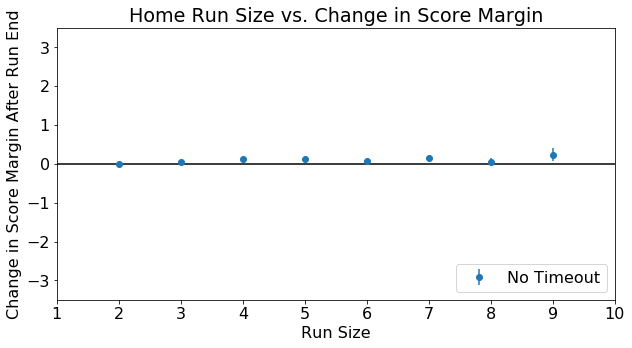

In [17]:
plot_averages(['NoT'], np_combined)

### Official Timeouts

Official timeouts are very informative because possession is effectively random, so we can avoid bias from a team's ability to set up scoring plays. As can be seen, an official timout is provides advantage to the ***home/running*** team. Traditional hypothesis testing shows that official timeouts help the home/running team with p <= 0.01. If calling a timeout serves to "settle" players, an official timeout should be just as effective as a "slipping" timeout. However, the timeout significantly hurts the slipping team. This result seems to challenge the idea that any stoppage helps the slipping team.  

Expected value of No Timeout:		0.11 +/- 0.07
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     27.32
Date:                Wed, 21 Feb 2018   Prob (F-statistic):            0.00122
Time:                        11:51:30   Log-Likelihood:                 11.760
No. Observations:                   8   AIC:                            -21.52
Df Residuals:                       7   BIC:                            -21.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1     

/home/mattfred/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


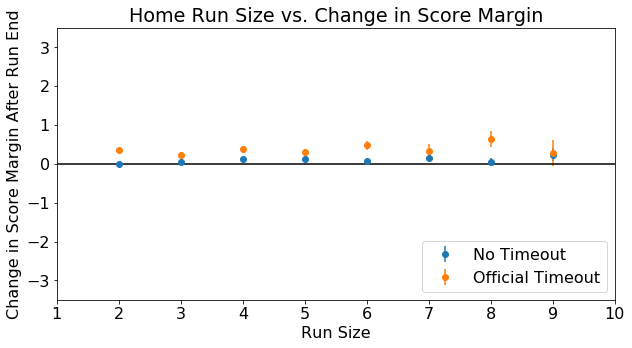

In [18]:
plot_averages(['NoT', 'OT'], np_combined)

### Home/Runner Timeout

When the home/running team calls a timeout, the score margin ***increases*** compared with no timeout or an official timeout. As can be seen from the error bars, there are not surprisingly few examples of the home/running team calling a timeout  

In [ ]:
plot_averages(['NoT', 'OT', 'HT'], np_combined)
#plot_averages(seq_values.keys())

### Away/Slipper Timeout

Okay, okay, "What about the slipping/away teams!?" you ask. Well, as shown below, we can very clearly see that there is ***no benefit*** to calling a timeout as the away/slipper compared with no timeout (and maybe even worse if we exclude 1-point "runs").

Expected value of No Timeout:		0.11 +/- 0.07
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     27.32
Date:                Wed, 21 Feb 2018   Prob (F-statistic):            0.00122
Time:                        11:55:06   Log-Likelihood:                 11.760
No. Observations:                   8   AIC:                            -21.52
Df Residuals:                       7   BIC:                            -21.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1     

/home/mattfred/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


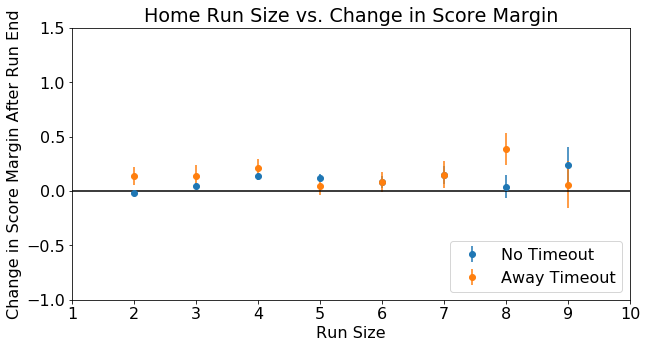

In [19]:
plot_averages(['NoT', 'AT'], np_combined,ylim=(-1,1.5))

## Runs by the Away Team

The axes are reversed so the trends are spatially the same as above. Note that the running team is now indicated by negative points and a longer run is more negative. The run still increases to the right, and the benefit to the running team is still towards the top. 

The "away" run sequences have nearly the same features with the exception of an increase in the home court advantage. It appears to be much more difficult to sustain runs in nearly every case as the away team. I don't believe this is a particularly unexpected or contentious observation.

The score away timeout sequences with |value| > 7 should be somewhat doubted as there are very few examples of them (note the point at -8). However, the sequences with lower value have at least an order of magnitude more points, making them more reliable.

The regression toward zero of the one point runs is interesting as well. I'd suggest that perhaps crowd noise during free throws has something to do with this decrease in expected value 

All other features are the same, most importantly the absence of any kind of dependence of margin score on run size. 

Expected value of No Timeout:		0.83 +/- 0.18
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     14.37
Date:                Wed, 21 Feb 2018   Prob (F-statistic):            0.00679
Time:                        15:07:15   Log-Likelihood:                -4.5278
No. Observations:                   8   AIC:                             11.06
Df Residuals:                       7   BIC:                             11.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1     

/home/mattfred/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


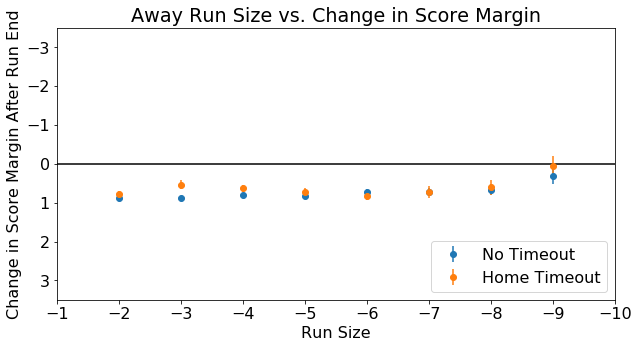

In [52]:
plot_averages(['NoT', 'HT'], np_combined, runner='Away')

In [27]:
print('Number -8 away timeout runs:\n', np_combined[(-8,'AT')].mean(), len(np_combined[(-8, 'AT')]))

Number -8 away timeout runs:
 2.36363636364 11


In [60]:
t_test('AT', 'NoT', np_combined, runner = "Home")
print()
t_test('HT', 'NoT', np_combined, runner = "Away")

8
run length	|	P value	|	T stat	|	Signigicant Better	|	Significant Worse
	2	|	0.074	|	1.790	|	True	|	False
	3	|	0.413	|	0.818	|	False	|	False
	4	|	0.369	|	0.898	|	False	|	False
	5	|	0.558	|	-0.770	|	False	|	False
	6	|	0.007	|	-0.008	|	False	|	True
	7	|	0.985	|	0.018	|	False	|	False
	8	|	0.055	|	1.919	|	True	|	False
	9	|	0.491	|	-0.661	|	False	|	False

8
run length	|	P value	|	T stat	|	Signigicant Better	|	Significant Worse
	-9	|	0.494	|	-0.666	|	False	|	False
	-8	|	0.214	|	-0.272	|	False	|	False
	-7	|	0.959	|	0.051	|	False	|	False
	-6	|	0.507	|	0.664	|	False	|	False
	-5	|	0.677	|	-0.988	|	False	|	False
	-4	|	0.888	|	-1.589	|	False	|	False
	-3	|	0.995	|	-2.789	|	False	|	False
	-2	|	0.765	|	-1.188	|	False	|	False


In [ ]:
np.array([np_combined[(-8,'AT')]for i in range(-10,0):  

## Conclusions

All of this analysis is performed with broad strokes. Coaches know their teams and train them to expect different strategies and 

For example, while the aggregate data seem to indicate that timeouts do not settle players, individual coaches definitely have the ability to recognize when their team may benefit from a timeout to settle down.

The high frequency of timeouts once again complicates the analysis as it seems questionable to consider a timeout effective if multiple are called, but in this work, we ignore this complication and look strictly at the expected point gain/loss.

Thus, Roy Williams should feel vindicated in his refusal to call these timeouts that apparently have the exact opposite effect that fans and coaches seems to think. Not that he needs it with <a href="http://scout.com/college/north-carolina/Bolt/LOOK-UNCs-2017-National-Championship-Rings-107146391">his rings.</a>

## Supplemental Information

I was curious whethere there were any effects of parity on these results (that is, counting the next few scores as an even number or an odd number). To address this concern, I also calculate the same results using the next 3 scores instead of the next 4 scores. There were no noticeable differences.

Similarly, I calculated 5 and 6 scores. The only noticeable effect was a systematic decrease in the size of effects. That is, there is a general regression to zero average score margin as the post sequence length increases. This can be examined by altering the "scores" parameter in the "find_sequence_value" function.

The three score results are shown with their 4 score counterparts and indicated with "-1". These values are automatically calculated, so changing "scores" in find_sequence_value will automtically generate the "less one" sequences.

In [ ]:
#plot_averages(seq_values.keys(), np_combined) # Universally biases towards away team as expected
plot_averages(seq_values.keys(), np_combined, team='Away')

In [ ]:
# Nice little alert to let me know when the Notebook has finished
from IPython.display import HTML
HTML('''<script>
alert('Done!')
</script>''')